In [1]:
import os
import sys 
sys.path.append(os.path.abspath('..'))
from get_utils import return_ignore, get_data, get_dir
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from tdr import build_tdr, project_onto_map, orth_wrt_map
import torch as th
import scipy.stats as stats
import plot as plot
from matplotlib.colors import ListedColormap




#%matplotlib qt
#%matplotlib widget
%matplotlib inline

In [2]:
loss_type = 'lateral' # I chose lateral deviation as the loss function


phases = {'NF1':[0],'FF1':[8],'NF2':[0],'FF2':[8]}
labels = ['NF1','FF1','NF2','FF2']
palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}



fontsize_label = 8
fontsize_tick = 8
fontsize_legend = 8

base_dir = os.path.join(os.path.expanduser('~'),'Documents','Data','MotorNet')
save_fig = '/Users/mahdiyar/Dropbox (Personal)/MotorSavings/paper/figures_raw'
if not os.path.exists(save_fig):
    save_fig = os.getcwd()  # Set current directory as save_dir if save_dir doesn't exist

In [3]:
n_model = 40 # number of simulated networks
network_siz = 128
folder_name = f'Sim_fixed_{network_siz}'
n_muscle = 6

palette_colors = {'FF1':(0,0.5,0),'FF2':(0.4,0.4,0.8),'NF1':(0,0,0),'NF2':(0,0,0)}

In [4]:
np.linspace(5,45,11)

array([ 5.,  9., 13., 17., 21., 25., 29., 33., 37., 41., 45.])

In [5]:
N_idx = 40#16 # 16 # time point just before the reach onset
F_idx = 59#25 # 25 # time point just after the reach onset

T = pd.DataFrame()

for s in [128]:
    print(f'Network size: {s}')
    network_siz = s
    folder_name = f'Sim_fixed_{network_siz}'
    ignore = return_ignore(folder_name,n_model) # sometimes some of cpus fail so we want to ignore those models


    for mn in range(n_model):
        model_name = "model{:02d}".format(mn)
        if mn in ignore:
            continue


        # 0. Load weights
        weight_file,_,_= get_dir(folder_name,model_name,'NF1',0)
        W = th.load(weight_file)['fc.weight'].numpy()
        U, S, Vh = np.linalg.svd(W, full_matrices=True)
        V = Vh.T
        P = V[:,:n_muscle] # output potent
        N = V[:,n_muscle:] # output null
        
        # 1. Load data
        U = get_data(folder_name,model_name,phases,n_hidden=network_siz)

        for N_idx in np.linspace(5,45,5):
            data = []
            force = []
            for i in range(len(U)):
                data.append(np.array(U[i]['all_hidden'])[:,int(N_idx),:])
                force.append(np.array(U[i]['endpoint_force'])[:,F_idx,:])

            # 1 build TDR
            combined_N = np.vstack(data)
            mean_N = np.mean(combined_N, axis=0)

            X = force[0] # NF1 force 
            N = data[0]-mean_N # NF1 hidden activity

            tdr = build_tdr(X,N)

            # 2 uniform shift from NF1 to FF1
            us = np.mean(data[1]-data[0],axis=0).reshape(-1,1)
            us_orth_norm = orth_wrt_map(us,tdr)
            #us_orth_norm = orth_wrt_map(us,P)
            #us_orth_norm = us


            # 2.1 Baseline FF1
            _, loss_np = get_data(folder_name,model_name,{'NF1':[0]},[8],n_hidden=network_siz,return_loss=True) 
            loss_ff1 = loss_np[0][loss_type].mean()

            # 3. perturb hidden
            for mag in [-1.0,1.0,0]:#np.linspace(-1.5,1.5,7): # positive and negative perturbation
                d_hidden = th.from_numpy(mag*us_orth_norm.T)

                # now lets perturb or not and calculate the saving in behavior
                _, loss_p = get_data(folder_name,model_name,{'NF2':[0]},[8],n_hidden=network_siz,disturb_hidden=True,t_disturb_hidden=N_idx/100,d_hidden=d_hidden,return_loss=True)

                loss_ff2 = loss_p[0][loss_type].mean()

                d = {'size':[network_siz]*2,'N':[N_idx]*2,'m':[mn]*2,'loss':[loss_ff1,loss_ff2],'phase':['FF1','FF2'],'mag':[0,mag]}
                T = pd.concat([T,pd.DataFrame(d)],ignore_index=True)

T.to_csv(base_dir+'/perturb3.csv',index=False)

Network size: 128


<Axes: xlabel='N', ylabel='loss'>

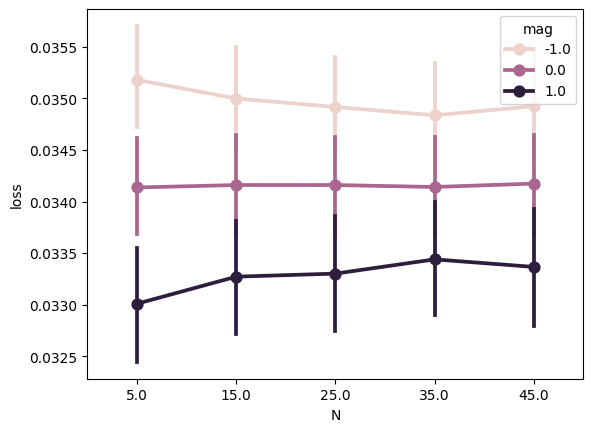

In [6]:
T = pd.read_csv(base_dir+'/perturb3.csv')

filter_condition = (
    (T['phase'] == 'FF2'))
T = T[filter_condition].reset_index(drop=True)
T
sb.pointplot(x='N', y='loss', data=T,hue='mag') #,errorbar=None


# plot

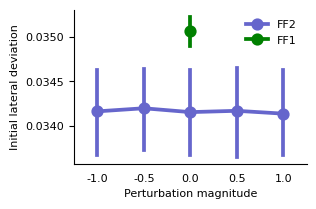

In [8]:
T = pd.read_csv(base_dir+'/perturb2.csv')


filter_condition = (
    (T['mag'].isin([-1,-0.5,0,0.5,1])) &
    (T['size'] == 128)
)
T = T[filter_condition].reset_index(drop=True)

fig, ax = plt.subplots(1, 1, figsize=(3, 2))
sb.pointplot(x='mag', y='loss', data=T, ax=ax,hue='phase',palette=palette_colors) #,errorbar=None


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_tick_params(labelsize=fontsize_tick)
ax.yaxis.set_tick_params(labelsize=fontsize_tick)
ax.tick_params(bottom = False) 
ax.set_xlabel('Perturbation magnitude', fontsize = fontsize_label)
ax.set_ylabel('Initial lateral deviation', fontsize = fontsize_label)

ax.legend(fontsize=fontsize_legend,loc='upper right',frameon = False)
fig.savefig(os.path.join(save_fig,'perturbation.pdf'),dpi=300,bbox_inches='tight')